In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager
import scipy


<module 'scipy.stats' from 'C:\\Users\\Santhosh\\Anaconda3\\envs\\tf-gpu\\lib\\site-packages\\scipy\\stats\\__init__.py'>

In [2]:
from pyod.models.abod import ABOD
from pyod.models.knn import KNN

In [6]:
from pyod.utils.data import generate_data, get_outliers_inliers

In [20]:
#generate random data with two features
X_train, y_train = generate_data(n_train=200, train_only=True, n_features=2)

In [21]:
#by default the outlier fraction is 0.1 in generate data function
outlier_fraction=0.1

#Store Outliers and inliers in different numpy arays
x_outliers, x_inliers = get_outliers_inliers(X_train, y_train)

In [22]:
n_inliers = len(x_inliers)
n_outliers = len(x_outliers)

In [23]:
#seperate the two data and use it to ployt the data
F1=X_train[:,[0]].reshape(-1,1)
F2=X_train[:,[1]].reshape(-1,1)

In [24]:
#create a meshgrid
xx,yy = np.meshgrid(np.linspace(-10,10,200), np.linspace(-10,10,200))

Text(0, 0.5, 'F2')

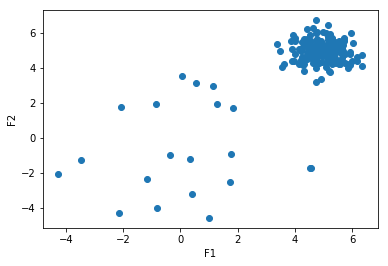

In [25]:
#scattr plot

plt.scatter(F1,F2)
plt.xlabel('F1')
plt.ylabel('F2')

In [26]:
#create a dictionary and add all the models that you want to use to detect the outliers
classifiers = {
    'Angle-based Outlier Detector (ABOD)' : ABOD(contamination=outlier_fraction),
    'K Nearet Neighbors (KNN)' : KNN(contamination=outlier_fraction)
}

No of Errors :  Angle-based Outlier Detector (ABOD) 4
No of Errors :  K Nearet Neighbors (KNN) 0


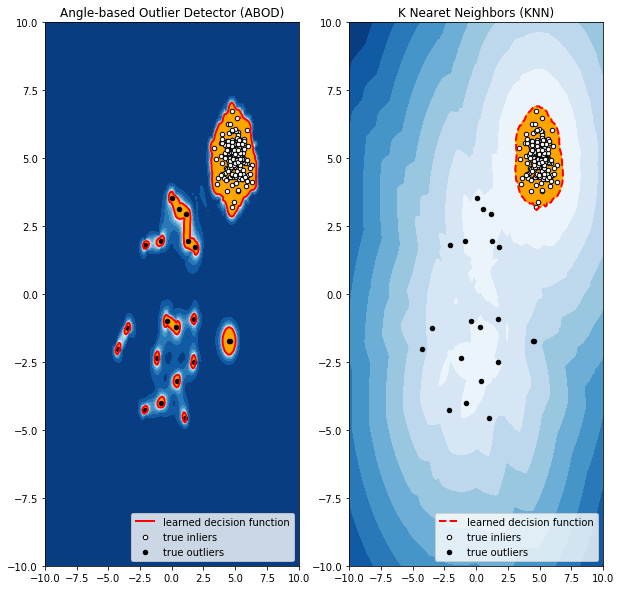

In [36]:
#set the fig size
plt.figure(figsize=(10,10))

for i, (clf_name,clf) in enumerate(classifiers.items()) :
    # fit the dataset to the model
    clf.fit(X_train)

    # predict raw anomaly score
    scores_pred = clf.decision_function(X_train)*-1

    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X_train)

    # no of errors in prediction
    n_errors = (y_pred != y_train).sum()
    print('No of Errors : ',clf_name, n_errors)

    # rest of the code is to create the visualization

    # threshold value to consider a datapoint inlier or outlier
    threshold = scipy.stats.scoreatpercentile(scores_pred,100 *outlier_fraction)
    

    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)

    subplot = plt.subplot(1, 2, i + 1)

    # fill blue colormap from minimum anomaly score to threshold value
    subplot.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 10),cmap=plt.cm.Blues_r)

    # draw red contour line where anomaly score is equal to threshold
    a = subplot.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')

    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')

    # scatter plot of inliers with white dots
    b = subplot.scatter(X_train[:-n_outliers, 0], X_train[:-n_outliers, 1], c='white',s=20, edgecolor='k') 
    # scatter plot of outliers with black dots
    c = subplot.scatter(X_train[-n_outliers:, 0], X_train[-n_outliers:, 1], c='black',s=20, edgecolor='k')
    subplot.axis('tight')

    subplot.legend(
        [a.collections[0], b, c],
        ['learned decision function', 'true inliers', 'true outliers'],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc='lower right')

    subplot.set_title(clf_name)
    subplot.set_xlim((-10, 10))
    subplot.set_ylim((-10, 10))
plt.show() 

In [38]:
import pandas as pd
import numpy as np

#import models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF

In [39]:
#REading the training data
df = pd.read_csv('Big_mart_sales_problem_Train.csv')

In [40]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


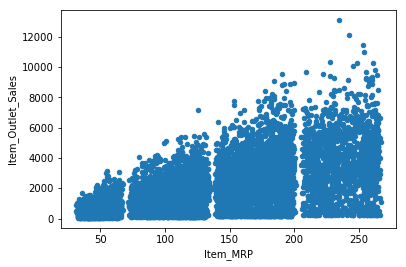

In [41]:
#Lets plot the item MRP with the Item Outlet sales
df.plot.scatter('Item_MRP','Item_Outlet_Sales')

In [43]:
#scaling the data between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

df[['Item_MRP','Item_Outlet_Sales']] = scaler.fit_transform(df[['Item_MRP','Item_Outlet_Sales']])
df[['Item_MRP','Item_Outlet_Sales']].head()

,Item_MRP,Item_Outlet_Sales
0,0.927507,0.283587
1,0.072068,0.031419
2,0.468288,0.158115
3,0.640093,0.053555
4,0.095805,0.073651


In [44]:
X1 = df['Item_MRP'].values.reshape(-1,1)
X2 = df['Item_Outlet_Sales'].values.reshape(-1,1)
X = np.concatenate((X1,X2), axis=1)

In [45]:
random_state = np.random.RandomState(42)
outliers_fraction = 0.05
# Define seven outlier detection tools to be compared
classifiers = {
        'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Average KNN': KNN(method='mean',contamination=outliers_fraction)
}

OUTLIERS :  447 INLIERS :  8076 Angle-based Outlier Detector (ABOD)


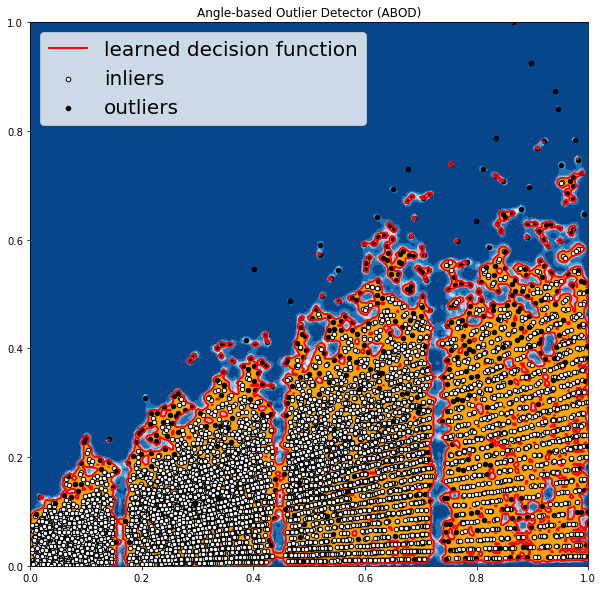

OUTLIERS :  427 INLIERS :  8096 Cluster-based Local Outlier Factor (CBLOF)


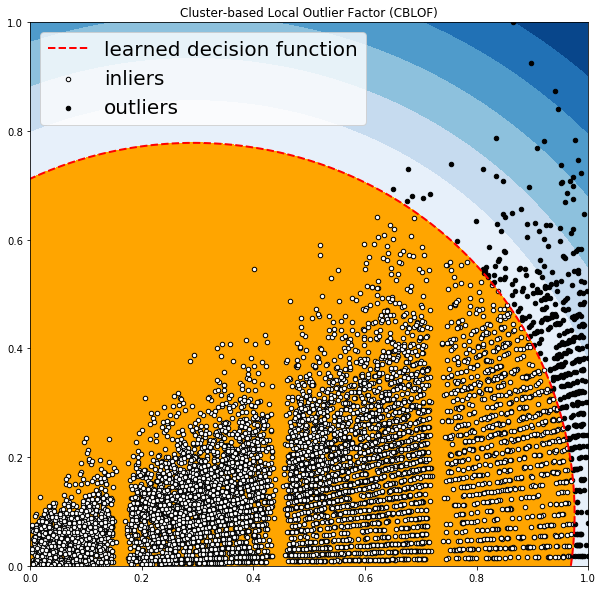

OUTLIERS :  340 INLIERS :  8183 Feature Bagging


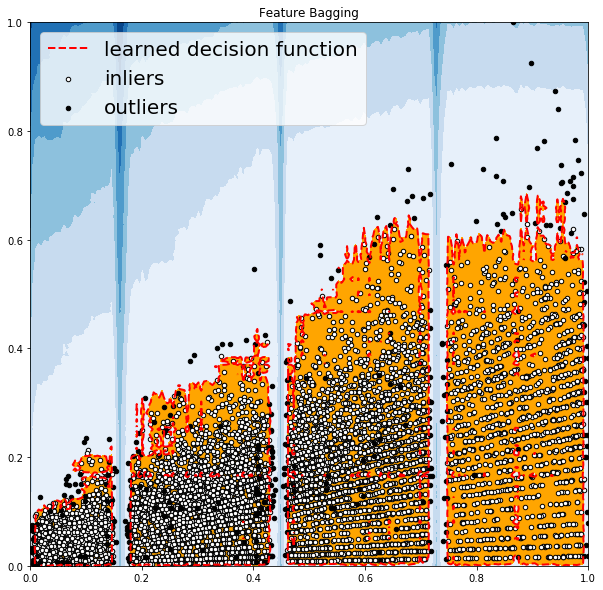

OUTLIERS :  501 INLIERS :  8022 Histogram-base Outlier Detection (HBOS)


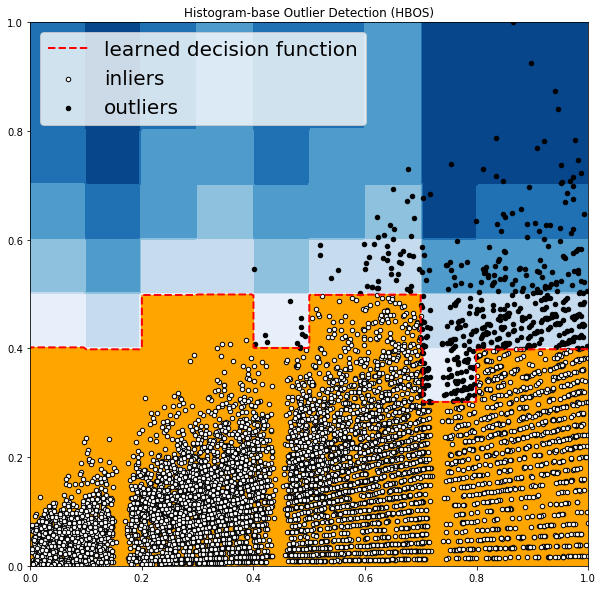

C:\Users\Santhosh\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


OUTLIERS :  427 INLIERS :  8096 Isolation Forest


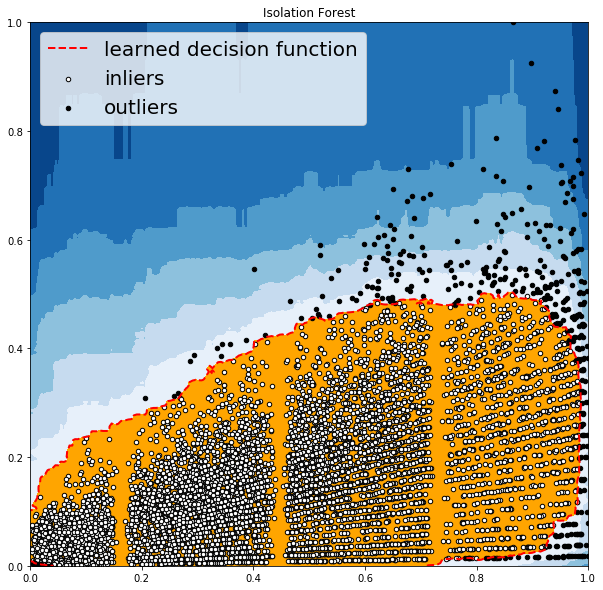

OUTLIERS :  311 INLIERS :  8212 K Nearest Neighbors (KNN)


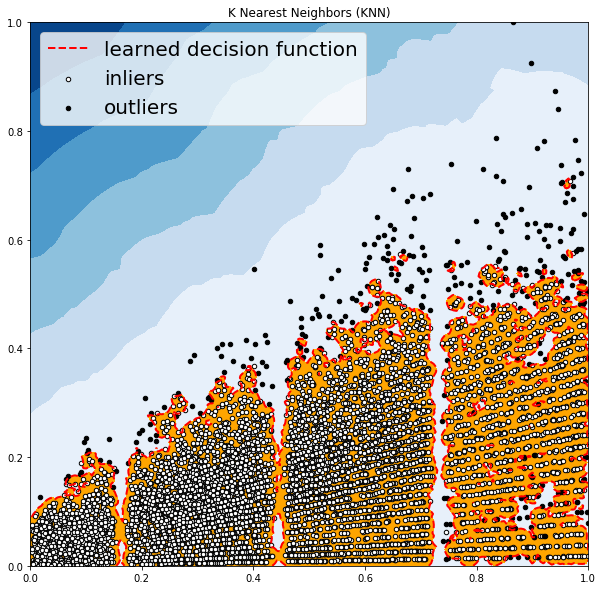

OUTLIERS :  176 INLIERS :  8347 Average KNN


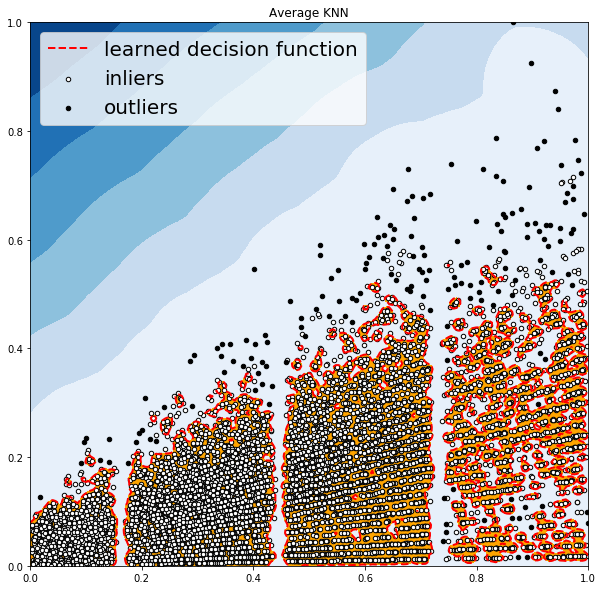

In [47]:
xx , yy = np.meshgrid(np.linspace(0,1 , 200), np.linspace(0, 1, 200))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(10, 10))
    
    # copy of dataframe
    dfx = df
    dfx['outlier'] = y_pred.tolist()
    
    # IX1 - inlier feature 1,  IX2 - inlier feature 2
    IX1 =  np.array(dfx['Item_MRP'][dfx['outlier'] == 0]).reshape(-1,1)
    IX2 =  np.array(dfx['Item_Outlet_Sales'][dfx['outlier'] == 0]).reshape(-1,1)
    
    # OX1 - outlier feature 1, OX2 - outlier feature 2
    OX1 =  dfx['Item_MRP'][dfx['outlier'] == 1].values.reshape(-1,1)
    OX2 =  dfx['Item_Outlet_Sales'][dfx['outlier'] == 1].values.reshape(-1,1)
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        
    # threshold value to consider a datapoint inlier or outlier
    threshold = scipy.stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
        
    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
          
    # fill blue map colormap from minimum anomaly score to threshold value
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
    # draw red contour line where anomaly score is equal to thresold
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
        
    b = plt.scatter(IX1,IX2, c='white',s=20, edgecolor='k')
    
    c = plt.scatter(OX1,OX2, c='black',s=20, edgecolor='k')
       
    plt.axis('tight')  
    
    # loc=2 is used for the top left corner 
    plt.legend(
        [a.collections[0], b,c],
        ['learned decision function', 'inliers','outliers'],
        prop=matplotlib.font_manager.FontProperties(size=20),
        loc=2)
      
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title(clf_name)
    plt.show()